# Hetionet Disease Characterization

## Disease characterization using DO
Ontology: http://disease-ontology.org/

In [4]:
library("igraph")

In [5]:
rm(list = ls())

In [6]:
options(warn=-1)

### Creating the ontology graph

In [7]:
fileontology <- read.csv("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/do_ontologyChildParent.tab", sep = "\t", header = F)
edges <- fileontology[c(1,2)]
nodes<- as.data.frame(unique(c(unique(as.character(edges[, 1])), unique(as.character(edges[,2])))))
colnames(nodes) <- "node"
graph.full = graph.data.frame(edges, directed=T, vertices=nodes)
nodes_int = vcount(graph.full) # number of nodes
edges_int = ecount(graph.full) # number of edges
cat('Full graph counts:\n')
cat('Number of nodes:', nodes_int)
cat('\nNumber of edges:', edges_int)

graph <- igraph::simplify(graph.full)
nodes_int = vcount(graph)  
edges_int = ecount(graph)
cat('\n\nSimplified graph counts:')
cat('\nNumber of nodes:', nodes_int)
cat('\nNumber of edges:', edges_int)

Full graph counts:
Number of nodes: 6931
Number of edges: 7131

Simplified graph counts:
Number of nodes: 6931
Number of edges: 7131

### Input: parent classes

In [8]:
fileparent <- read.csv("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/do_ontology1rstBranchParents.tab", sep = "\t", header = F)
parent <- fileparent[c(1)]
parent <- parent$V1
cat('\nNumber of parent classes:', length(unique(parent)))


Number of parent classes: 8

### Input: child classes

### Rephetio
It contains 137 terms called slim DO: 108 complex diseases from GWAS Catalog 
and 63 cancer terms from DO Cancer Slim subset.

Info: https://thinklab.com/discussion/unifying-disease-vocabularies/44#144

Data downloaded from: https://neo4j.het.io/browser/

Data: https://github.com/dhimmel/learn/blob/5e61aed9789913d5b3525bb83eba80e0fcc060a4/summary/diseases.tsv

In [18]:
filechild <- read.csv("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/hetionet-doids-list.tab", sep = "\t", header = F)
child <- filechild[c(1)]
child <- child$V1
cat('\nNumber of child classes:', length(unique(child)))
child <- intersect(child,nodes$node)
cat('\nNumber of child classes in DO:',length(unique(child)))


Number of child classes: 137
Number of child classes in DO: 136

### Output: child -> parent pathways 

In [7]:
resultsPathways  <- data.frame(t(rep(NA,3)))
colnames(resultsPathways ) <- c("child", "parent", "length")

### Algorithm

In [8]:
c <- 1  
for (node1 in child ){     
  for (node2 in parent){       
    sp <- get.shortest.paths(graph,from = node1, to = node2, mode = "out")
    
    if (length(sp$vpath[[1]]) > 0){
      l <- length(sp$vpath[[1]])
      resultsPathways[c, 1] <- node1
      resultsPathways[c, 2] <- node2      
      resultsPathways[c, 3] <- l # original row
      c<- c+1
    }
  }
}

### Save results

In [9]:
str(resultsPathways)
write.csv(resultsPathways,"/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/hetionet-doidsPathways.csv")

'data.frame':	136 obs. of  3 variables:
 $ child : chr  "DOID:4606" "DOID:8778" "DOID:1793" "DOID:11612" ...
 $ parent: chr  "DOID:14566" "DOID:7" "DOID:14566" "DOID:225" ...
 $ length: int  6 5 5 2 4 10 6 6 7 7 ...


### Disease class distribution

In [10]:
hetioPathways <- resultsPathways
hetio.freq = table(sort(hetioPathways$parent))
hetio.freq.df = as.data.frame(hetio.freq)
colnames(hetio.freq.df)[1] = 'doid'
hetio.percent = prop.table(hetio.freq)*100
hetio.percent.df <- as.data.frame(hetio.percent)
colnames(hetio.percent.df) = c('doid', 'Percent')
colnames(fileparent) = c('doid','name')
hetio.percent.df.merge = merge(fileparent, hetio.freq.df, by.x = 'doid', all.x = T)
hetio.percent.df.merge$Freq[is.na(hetio.percent.df.merge$Freq)] = 0
hetio.percent.df.merge = merge(hetio.percent.df.merge, hetio.percent.df, by.x = 'doid', all.x = T)
hetio.percent.df.merge$Percent[is.na(hetio.percent.df.merge$Percent)] = 0
hetio.percent.df.merge = hetio.percent.df.merge[order(-hetio.percent.df.merge$Percent),]
hetio.percent.df.merge

,doid,name,Freq,Percent
8,DOID:7,disease of anatomical entity,57,41.9117647
4,DOID:14566,disease of cellular proliferation,56,41.1764706
5,DOID:150,disease of mental health,11,8.0882353
1,DOID:0014667,disease of metabolism,5,3.6764706
2,DOID:0050117,disease by infectious agent,4,2.9411765
6,DOID:225,syndrome,2,1.4705882
3,DOID:0080015,physical disorder,1,0.7352941
7,DOID:630,genetic disease,0,0.0000000


### Save graphic

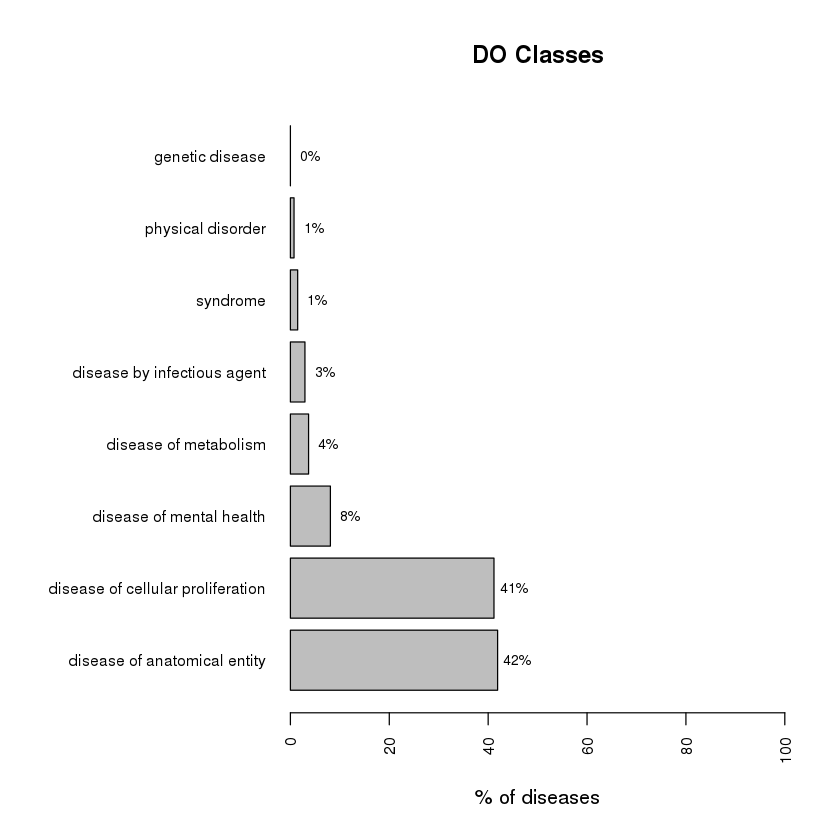

In [19]:
#png("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/hetionet-doids-classes-percent.png",width=1700,height=960, units = "px", pointsize = 18)
par(oma=c(.2,8.,.2,.2))
f1bp <- barplot(hetio.percent.df.merge$Percent, names.arg = hetio.percent.df.merge$name,las=2,cex.names=.8,xlim=c(0,100),main="DO Classes",xlab="% of diseases",cex.axis=.8,horiz=T)
text(hetio.percent.df.merge$Percent+4,f1bp,labels=paste0(as.character(round(hetio.percent.df.merge$Percent)),"%"),cex=.7,xpd=T)
#dev.off()

### DO coverage

### Input: all DO classes as child classes

In [12]:
filechild <- read.csv("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/allActIdDOOntology.tab", sep = "\t", header = F)
child <- filechild[c(1)]
child <- child$V1
cat('\nNumber of child classes:', length(unique(child)))
child <- intersect(child,nodes$node)
cat('\nNumber of child classes in DO:',length(unique(child)))


Number of child classes: 6931
Number of child classes in DO: 6931

### Output: child -> parent pathways

In [13]:
resultsPathways  <- data.frame(t(rep(NA,3)))
colnames(resultsPathways ) <- c("child", "parent", "length")

### Algorithm

In [14]:
c <- 1  
for (node1 in child ){     
  for (node2 in parent){       
    sp <- get.shortest.paths(graph,from = node1, to = node2, mode = "out")
    
    if (length(sp$vpath[[1]]) > 0){
      l <- length(sp$vpath[[1]])
      resultsPathways[c, 1] <- node1
      resultsPathways[c, 2] <- node2      
      resultsPathways[c, 3] <- l # original row
      c<- c+1
    }
  }
}

### Save results

In [15]:
str(resultsPathways)
write.csv(resultsPathways,"/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/hetionet-doOntologyChildsPathways.csv")

'data.frame':	6956 obs. of  3 variables:
 $ child : chr  "DOID:3127" "DOID:3121" "DOID:3120" "DOID:3122" ...
 $ parent: chr  "DOID:7" "DOID:14566" "DOID:14566" "DOID:7" ...
 $ length: int  5 6 7 4 5 7 7 5 7 6 ...


### Disease class distribution and DO coverage

In [16]:
doPathways <- resultsPathways
do.freq = table(sort(doPathways$parent))
do.df = as.data.frame(do.freq)
hetio.df = as.data.frame(hetio.freq)
colnames(do.df) = c('doid', 'doFreq'); colnames(hetio.df) = c('doid', 'hetioFreq')
hetio.parent.df = merge(fileparent, hetio.df, by.x = 'doid', all.x = T) #; hetio.parent.df
hetio.parent.df$hetioFreq[is.na(hetio.parent.df$hetioFreq)] = 0 #; hetio.parent.df
coverage.df = merge(hetio.parent.df, do.df, by.x = 'doid', all.x = T) #; coverage.df
coverage.df$percent = (coverage.df$hetioFreq*100)/coverage.df$doFreq #; coverage.df
coverage.df = coverage.df[order(-coverage.df$percent),]; coverage.df

,doid,name,hetioFreq,doFreq,percent
5,DOID:150,disease of mental health,11,228,4.824561
3,DOID:0080015,physical disorder,1,33,3.030303
4,DOID:14566,disease of cellular proliferation,56,2611,2.144772
6,DOID:225,syndrome,2,100,2.000000
8,DOID:7,disease of anatomical entity,57,2952,1.930894
1,DOID:0014667,disease of metabolism,5,321,1.557632
2,DOID:0050117,disease by infectious agent,4,434,0.921659
7,DOID:630,genetic disease,0,277,0.000000


### Save graphic

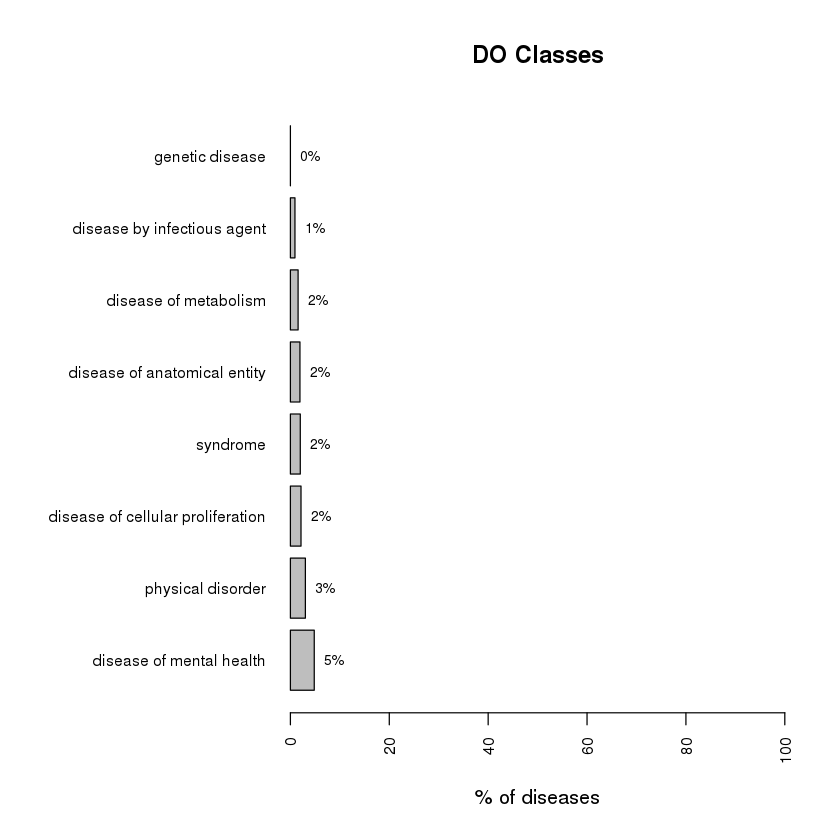

In [21]:
#png("/home/nuria/workspace/repurposing-hetio/rephetio-dhimmelstein/Characterization-Disease-Drug-Scope-of-hetio/out/hetionet-do-coverage-classes-percent.png",width=1700,height=960, units = "px", pointsize = 18)
par(oma=c(.2,8.,.2,.2))
f1bp <- barplot(coverage.df$percent, names.arg = coverage.df$name,las=2,cex.names=.8,xlim=c(0,100),main="DO Classes",xlab="% of diseases",cex.axis=.8,horiz=T)
text(coverage.df$percent+4,f1bp,labels=paste0(as.character(round(coverage.df$percent)),"%"),cex=.7,xpd=T)
#dev.off()